## ShuffleNet v2

Source: https://arxiv.org/pdf/1807.11164.pdf

To continue off the research I had done previously on ShuffleNet, I wanted to take another look at an small net architecture and see what changes they made compared to ShuffleNet v1.

In the ShufflNet V2 paper, they state that computational complexity is measured in FLOPS, however, the direct (and arguably more important) metric can be measured by the speed of the network. Thus, in this paper they will be considering measuring network performance based on this direct metric and proposes guidelines for efficient network design. They present a new network architecture called ShuffleNet V2 and demonstrate that this model is state-of-the-art in balancing speed and accuracy.

While much of the academic papers have focused on improving accuracy, real world tasks aim to obtain optimal accuracy with limited computational complexity. For example, self-driving cars require networks that have extremely low latency. Such tasks have given rise to several networks, some of which we have already examined or may be examining in lecture such as Xception, MobileNet, MobileNetV2, ShuffleNet, and CondenseNet. As in the first ShuffleNet paper, I saw how group convolutions and depth-wise separable convolutions were the backbone of making these networks fast and efficient. In many papers we have examined on network architectures, we have seen FLOPs used as an indirect measure of the computational complexity. While the number of FLOPs is an important consideration in designing the network it is not a direct metric such as speed or latency which are usually of more importance. The paper provides an example of MobileNet v2 versus NASNET-A where each have comparable flops but MobileNet v2 is substantially faster. This further supports the notion that network design should not be based around an indirect measure such as FLOPs, but a direct measure. The figure below demonstrates this notion by shoping multiple networks with similar flops perform at different speeds.

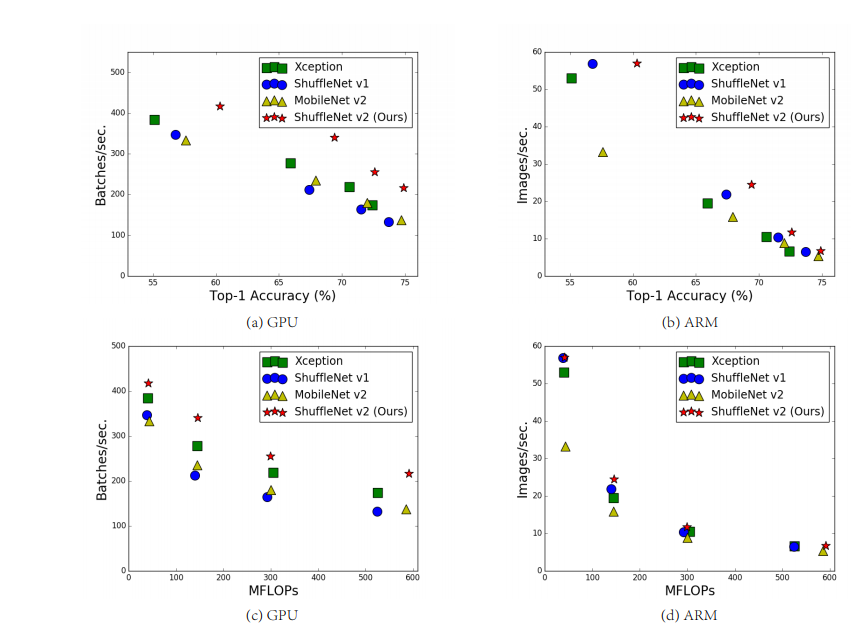

So what is the reason for these discrepancies? The first is called memory access cost (MAC). This contributes large overhead to operations such as group convolutions and can be the bottleneck on devices with strong computing power. In other words, a GPU can perform calculations much faster than it can access the data for these calculations. The other factor contributing to compute time is the degree of parallelism. This is a rather obvious point as if we can split up the computations to be run simultaneously, it would be natural that our network would be much faster. Another interesting point is that some operations with the same FLOPS have different run times that depend on the platform. The paper gives an example where an operation designed to reduce FLOPs by 75% is particularly slow on a GPU. This is largely due to the fact that the CUDNN library at the time of writing the paper was optimized for 3x3 convolutions. To rectify these inconsistencies, the researchers argue that we should follow two principles for effective network design:
1.  Use of direct measures, e.g. speed, instead of indirect measures such as FLOPs
2.  The metric should be evaluated on the target platform

In this paper, they examined performance of two state-of-the-art networks and then propose four guidelines for efficient network design based off the two principles above. Rather than testing everything on one platform, say GPU, they also evaluated their network's performance on ARM with dedicated optimizations. The proposed ShuffleNet v2 is not only faster than ShuffleNet, but achieves greater accuracy on both GPU and ARM platforms. The hardware and settings used in their experiments are:

- NVIDIA GeForce GTX 1080Ti with CUDNN 7.0. This is already an interesting choice as they chose not to use a card optimized for CUDA/Tensor cores, but one that is popularly used in home gaming PCs. 
- Qualcomm Snapdragon 810 (Arm NEON). Use of single thread for evaluation
- Tensor fusion for small operations
- Image size of 224 $\times$ 224
- Each network is randomly initialized, evaluated 100 times, and the average runtime is used

First they analyze the performance of ShuffleNet v1 and MobileNet v2, which are state-of-the-art models that perform well on the ImageNet task. The figure below decomposes the run times of the operations of each network. While convolutions do take the most time, data input/output, shuffling, and element wise operations contribute a large amount to rune time as well.

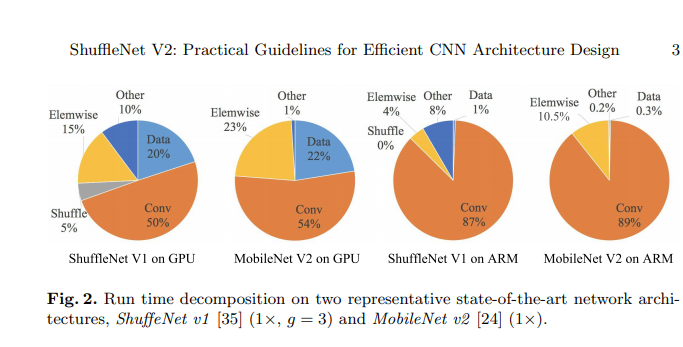

We now move on to the guidelines. 

#### Guideline 1: Equal channel width minimizes memory access cost (MAC)

Modern networks use depthwise separable convolutions in addition to 1x1 convolutions which account for the most complexity. Given an the number of input channels $c_1$ and output channels $c_2$, we calculate the FLOPs of the 1x1 convolution to be $hwc_1c_2$, where $h$ and $w$ are the spatial dimensions. To calculate the MAC (number of memory access operations), we take $hw(c_1+c_2)+c_1c_2$ where the first term is the input  of feature maps and the second is the output of kernel weights. From the mean value inequality we obtain: 

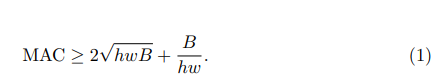

In words, this means that MAC is lower bounded by FLOPs and reaches this bound when $c_1$ and $c_2$ are equal. However, this is under the assumption that the cache in a device is large enough to store the entire feature map and parameters. In practice results are different as the cache typically not large enough to store such values. To validate this statement, the researchers stacked 10 building blocks repeatedly, each with two convolutional layers. The first contains $c_1$ input channels and $c_2$ output channels, and the second otherwise. Consider the following table: 

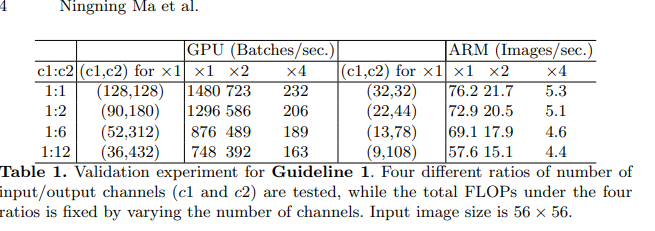

The table displays the speed at varying ratios $c_1:c_2$. Notice how the MAC decreases as the ratio approaches $1:1$, and that considerable overhead exists as the ratio widens despite the same number of FLOPs.

#### Guideline 2: Excessive group convolution increases MAC

We have seen group convolutions in many modern architectures throughout the semester to expand the width of networks. These have been used to drastically reduce computational complexity of models while retaining performance. They allow for more usage of channels given fixed FLOPs and, overall, increases the capacity of networks. However, the authors note that this does not come without a cost and that this cost may come in the form of an increase in MAC. The relation between MAC and FLOPs expressed mathematically is:

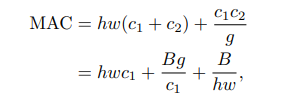

where $g$ is the number of groups and $B = hwc_1c_2/g$ is the FLOPs. Since $hwc_1$ is a constant and $g$ scales linearly in the second term, we can see that MAC increases as $g$ increases. Again, these are the results "on paper", and real world results will differ. To demonstrate the real world effects of a growth in $g$ 10 pointwise group convolutions are stacked and the results are reported in the table below. We see drastic differences between the highest and lowest group number, however, this effect is diminshed as $c$ increases when using GPU. The results are less pronounced when performing the same experiment on ARM, but the results show a similar trend. Considering these are all at the same FLOPs, it is a dramatic decrease in performance with more groups. This isn't to say we should choose the smallest group number, but to consider the platform that our network will exist on.

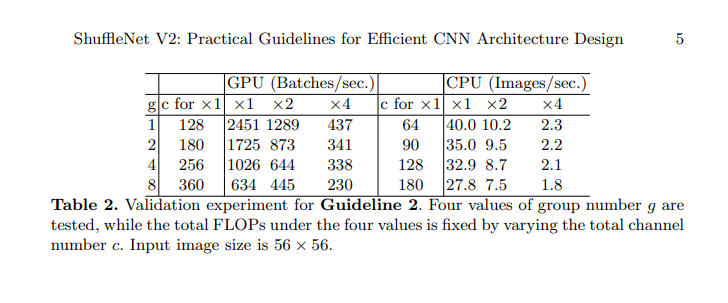

#### Guideline 3: Network fragmentation reduces degree of parallelism

Many recent architectures use larger numbers of fragmented operators in which individual convolution or poling operations exist in one building block. In "simpler" and earlier architectures such as ResNet, the number of these fragmented operations is much lower. While the former enhances accuracy, it decreases the degree of parallelism of the model and introduces additional overheads. To quantify how this network fragmentation impacts the efficiency of the model, the researchers looked at several network blocks with varying levels of fragmentation. The architecture of the fragmentation is demonstrated simply in the figure below. These blocks are then stacked 10 times in succession and the results are evaluated in the table below.
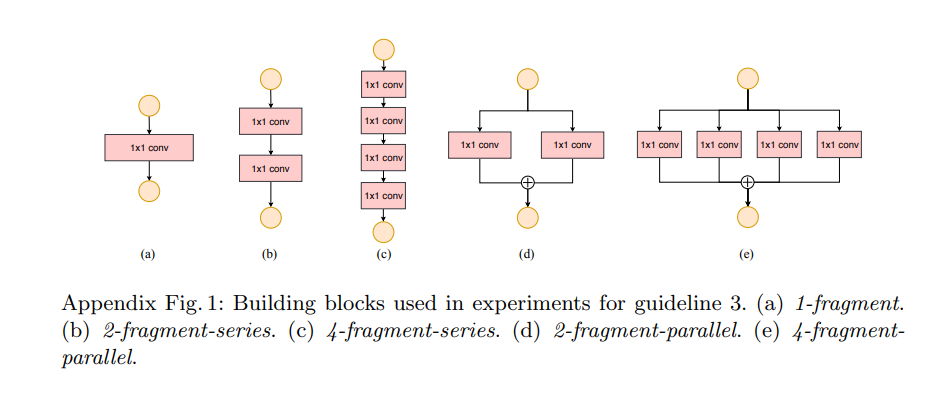
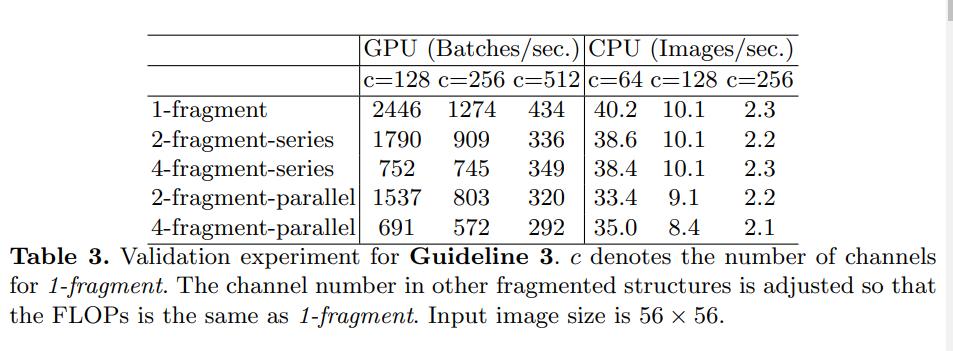

On GPU the difference is rather apparent, with grather fragmentation resulting in less batches/sec. However, on CPU it is interesting that the 2-fragment series and 4-fragment series are roughly the same in terms of images/sec. It appears that the trend is the decrease in images/sec is larger at lower fragments for CPU but diminishes as the fragmentation is increased, however, I do not think enough evidence is provided to fully support this observation.

#### Guideline 4: Element-wise operations are non-negligible

Element wise operations such as ReLU, AddTensor, AddBias (and others) pose as bottlenecks when in the context of GPU operations because of their high MAC. The paper also considers depthwise convolutions as an element-wise operation as it has a high MAC/FLOPs ratio. For this test, they modified the bottleneck units to remove the ReLU and shortcut operations, separately. They found a 20% increase in speed by both GPU and ARM after these operations are removed. Regardless of channels used, there was a consider increase in speed. Results are summarized in Table 4:

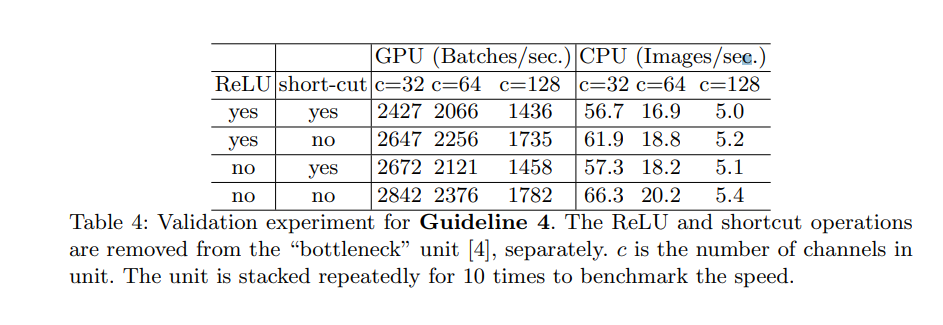


#### Conclusions and Discussions

From the findings above the researchers propose the following:

1. Use of balanced convolutions of equal channel width
2. Consider the cost of using group convolutions
3. Reduce fragmentation
4. Reduce element-wise operations

The operations above primarily focus on the cost of MAC in slowing down the network. While the FLOPs may not indiciate that a model is particularly complex, the MAC can still be considerably high and thus affect model speed. They note that predecessors such as ShuffleNet v1, MobileNet (v1 and v2), and auto generated structures all violate one or more of these guidelines above.

Let us move on to the new proposed architecture, ShuffleNet v2 which builds off of the previous work from ShuffleNet v1. Previous research indicates that a limited number of feature channels is the main obstacle for light-weight networks. Pointwise group convolutions and bottleneck structures have been used to overcome this, as seen in ShuffleNet v1. Additionally, channel shuffling was introducted in ShuffleNet v1 which allowed for information sharing between different groups of channels. However, the issue with ShuffleNet v1 is that it violates guidelines 1 and 2 which dramatically increase MAC. They also note that they used too many group convolutions (guideline 3) and that the residual connection is undesirable (guideline 4). They wanted to maintain a comprable network width without introducing too many dense convoltuions or groups.

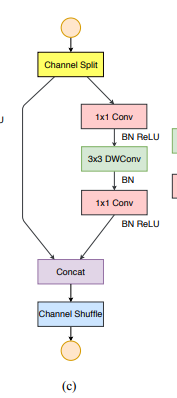

The solution comes as a channel split operation which is pictured above. The input of $c$ channels are split into two branches with one branch having $c-c'$ channels and the other $c'$. One branch still reamins the idendity branch (guideline 3) while the other consists of 3 convolutions with the same input and output channels (guideline 1). Pointwise group convolutions are removed and regular 1x1 convolutions are used instead to adhere to guideline two and that we already in a sense produce two groups. Then the branches are concatenated and the number of channels is kept the same (guideline 1). Chanel shuffling is still used to enable for information sharing between the branches and the blocks are then repeated. Element-wise operations are kept in one branch and the three element-wise operations concat, channel shuffle, and channel split are merged into a single element-wise operation (guideline 4). For spatial downsampling, we remove the channel split operator and the number of output channels is doubled. Using these methods (with and without spatial downsampling), the researchers have a very efficient network--ShuffleNet v2. In ShuffleNet v2 $c'=c/2$ and the structure is similar to that of ShuffleNet v1. The structure is provided below.

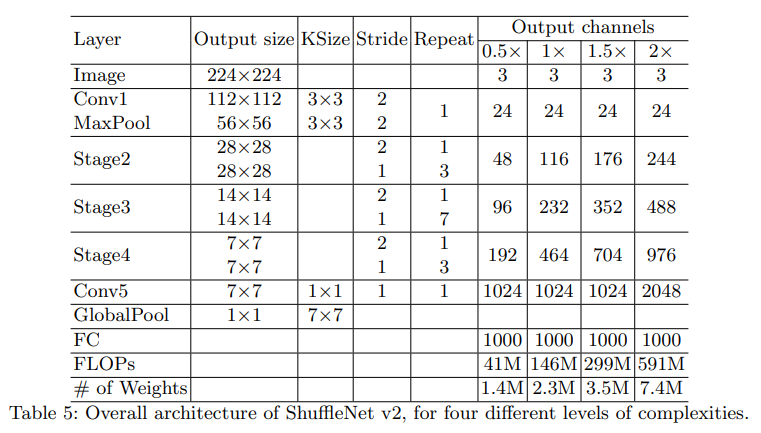



Because the aim was to build a highly efficient network, ShuffleNet v2 is able to have greater capacity while still being quite fast and thus result in better accuracy. The researchers also note that the channel split allows for "feature reuse" which shares similarities with DenseNet and CondenseNet. To cleverly illustrate this, the l1-norm of weights between adjacent layers are plotted and it can be seen that the connects between these layers are more pronounced than other (non adjacent) layers. We can see this in the following heatmap:

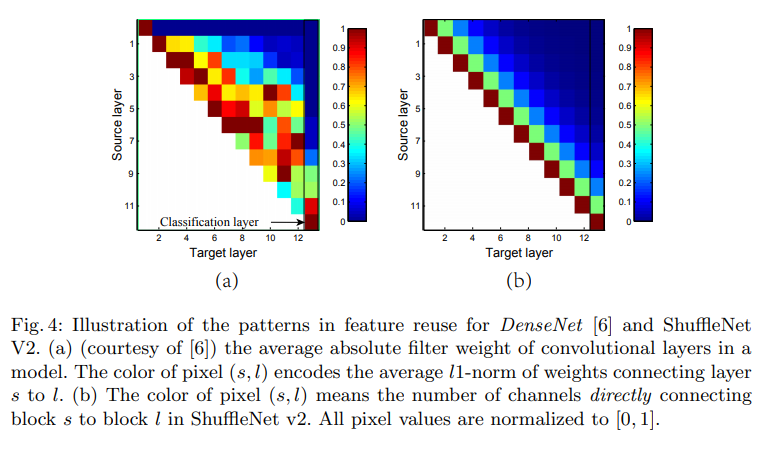

So if we look at (b) above, and focus on layer 1 we see that as we move right that the average l1-norm decays to 0 quite rapidly. In ShuffleNet v2, the feature reuse decays exponentially with distance and it can be shown that the directly connected channels between the i-th and (i+j)-th block is $r^jc$ where $r = (1-c')$. This feature reuse has shown to have positive effects on model performance as illustrated in DenseNet and what is found in ShuffleNet v2 can be considered a more efficient method of what is found in DenseNet.

For their testing with ShuffleNet v2, they used the ImageNet classification dataset and tested at different computational complexities of 40, 140, 300, and 500+ MFLOPs. Other hyperparameters are the exact same as in ShuffleNet v1. They will make the following comparisons between network architectures:
- ShuffleNet v1: g = 3 is used to trade off between accuracy and speed. In ShuffleNet v2, g = 3 is primarily used.
- MobileNet v2: Comparing to results provided in the original paper as well as their own re-implementation.
- Xception: Using the light weight version of the Xception structure
- DenseNet: Same archtiecture as in Table 5 above, except with blocks being replaced with DenseNet blocks for stages 2-4. Channels are changed to adjust for computational complexity. 

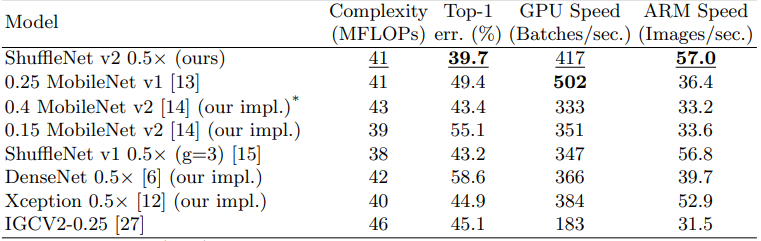

The full table for comparison of results is quite large, so I have included a portion above at the lowest level of complexity (MFLOPs). It is clear that ShuffleNet v2 destroys its competition while balancing speed and accuracy. This trend is similar at higher complexities as well. First is the comparison of Accuracy vs. FLOPs. MobileNet v2 performs poorly at low computational budgets likely because there are too few channels given an image size of 224 $\times$ 224. This demonstrates that the ability to have a wide network at low complexity contributes greatly to MobileNet v2's performance.

Next, inference speed vs FLOPs/Accuracy. For the best performing networks--Shufflenetv v2, MobileNet v2, ShuffleNet v1, and Xception--they compared the actual speed vs FLOPs. ShuffleNet v2 is considerably faster than the other networks on GPU and on par with ShuffleNet v1 and Xception on ARM, with MobileNet v2 being much slower. They hypothesize MobileNet v2 performs poorly due to its higher MAC which takes a huge toll on mobile devices. While MobileNet v1 is extremely fast due to its adherence to the proposed guidelines it suffers from poor accuracy. IGCV2 and IGCV3 are very slow due to too many convolution groups. For automatic model search they also found that speeds were slow due to high fragmentation of the networks. They propose that including their guidelines in the model search algorithms could have promising results.

For compatability with other methods, ShuffleNet v2 was testing with a squeeze and excitation module which improved accuracy but decreased network speed. They also propose that ShuffleNet v2 can be scaled to use for large models. They create a 50-layer ShuffletNet v2 and compare it to an equivalent ShuffleNet v1 and ResNet-50. ShuffleNet v2 in this scenario outperforms ShuffleNet v1 and beats ResNet-50 with 40% fewer FLOPs! They also tested a 164-layer ShuffleNet v2 with residual paths for faster training which outperformed state-of-the-art models with much fewer FLOPs.

Finally, we look at comparisons with object detection using the MS COCO dataset. They use Light-Head RCNN as the framework as it is a light-weight model. Models are then pretrained on ImageNet and finetuned on the detection task. The minival set is used for testing and the train and val sets are using for training. ShuffleNet v2 is compared to Xception, ShuffleNet v1 and MobileNet v2 with 4 levels of complexities where it is found to perform the best. The results for testing on MS COCO can be found below. Shufflenet v2 again ranks as the best model, but Xception replaces MobileNet v2 as the second best model. They expect this change is due to the larger receptive field of the Xception building blocks, and change ChuffleNet v2 to have a wider receptive field as well. They do so by using an additional 3x3 depthwise convolution in each block. This new variant increases accuracy with little FLOPs and is denoted ShuffleNet v2*. Overall, speed was best on ShuffleNet v2 (and ShuffleNet v2*).

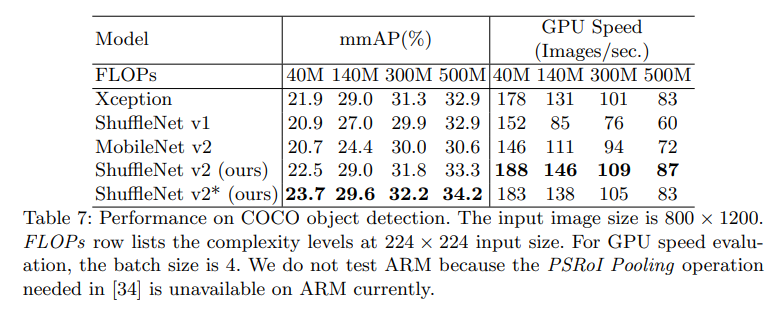



This paper layed out the argument that we should be considering a direct metric such as speed, rather than FLOPs. They also proposed guidelines to follow to achieve an efficient network design. These points were supported through experiments and comparison among state of the art networks for accuracy and speed. After all, many applications of networks may not arise in academic settings or tech companies with vast computing resources--these models must serve a purpose that require results in real time.

### Paper 2: FCOS: Fully Convolutional One-Stage Object Detection

Source: https://openaccess.thecvf.com/content_ICCV_2019/papers/Tian_FCOS_Fully_Convolutional_One-Stage_Object_Detection_ICCV_2019_paper.pdf

The fully convolutional one-stage object detector (FCOS) differentiates itself from other object detection models by eliminating the pre defined anchor boxes and is proposal free. By eliminating these, the model becomes computationally cheaper. They also avoid the use of hyperparameters relating to anchor boxes to avoid sensitivity in final detection performance. Compared to other single stage detectors, the researchers propose that their methodology is much simpler and that they are able to achieve better detection accuracy.

As noted by the paper at the time the current state of the art models for detection are Faster R-CNN, SSD, and YOLOv2/v3 which all rely on anchor boxes that have already been defined. However, this is actually the drawback of these models as performance can be sensitive to size, aspect ratios, and the number of anchor boxes. Another drawback is that the scales and aspect ratios of anchor boxes are fixed and these models may struggle to detect objects when there is a great deal of variation in the size of an object. Generalization is hindered by the pre-defined anchor boxes since they are generall task specific as well. Additionally, the number of anchor boxes can be substantially large thus resulting in computation inefficiencies since many of the boxes are not the desired class (or background) and can result in substantial class imbalance. Finally, the boxes require the calculation of the intersection over union score with ground truth bounding boxes which further introduces computation complexity.

Fully convolutional networks (FCNs) have been gaining ground in dense prediction tasks, however, they have not seen their use in object detection primarily to the prevalence of bounding boxes. The researchers pose the question: "Can we solve object detection in the neat per-pixel prediction fashion, analogue to FCN for semantic segmentation, for example?". Not surprisingly, the answer is yes and is he focus of this paper. What is surprising, though, is that this new framework achieves better performance than the previous state of the art models. In prior works, there were some attmpted uses of FCNs for object detection (namely Dense-Box). Dense-Box cropped and resizes training images to a fixed scale and utilizes image pyramids which the authors note is counter_____ to FCNs. Furthermore, these methods have typically been very domain specific in scene text/face detection and have not seen widespread use in general object detection with overlapping bounding boxes. This is because when the bounding boxes overlap there are issues with which box to regress on (pictured in the figure below).

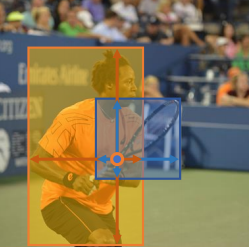

The proposed methodology produces state of the art performance by utilizing feature pyramid networks can solve the previously stated issue. However, the proposed methodology can struggle to construct high-quality predicted bounding boxes for locations that stray from the center of the target object. They introduce a new center-ness branch to account for this issue, which will be discussed in more detail later. In short, this method will be used to detect poor bounding boxes and down weight them in non maximum supression. In other words, we find a list of initial bounding boxes with the highest detection scores and merge them until there is only one bounding box.

What are the advantages of the new method?
- Reusability with other FCN tasks such as semantic segmentation
- Proposal/Anchor free thus resulting in simpler computation and easier training
- FCOS can be used as region proposal networks in two-stage detectors for better performance
- State of the art performance

Now we move on to the related works where we will first examine Anchor-based detectors. Anchor based detectors utilize sliding windows/proposals which are identified as a positive or negative patch and mechanisms to refine the prediction of bounding boxes. In this case anchor boxes can be considered the training examples and use feature maps from CNNs to avoid recalculating repeated features. While this method was not used in Fast R-CNN, it is used in architectures such as Faster R-CNN and YOLOv2 and has become widespread since. The downside of this method is that tuning of hyper-parameters is needed and that some of these hyper-parameters themselves have hyperparameters, thus increasing the complexity of the tuning process. Anchor free detectors, such as YOLOv1, predict bounding boxes near the center of objcets. The points near the center are used since they result in better detection but suffers from low recall. FCOS utilizes the centerness idea from YOLOv1 but alters it with their novel center-ness branch and thus improve recall. Another architecture, CornerNet, is a one-stage anchor free dectector that as the name suggests, detects corners of a bounding box to form the predicted bounding box.

Moving on to the researcher's approach. Initially, their explanation is somewhat mathematical so I will paste the section as an image below.

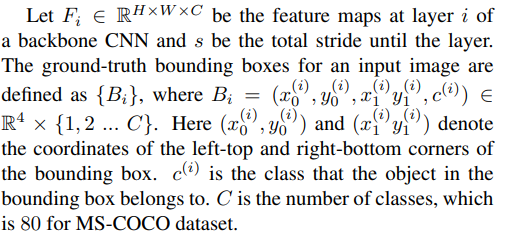

So far, things are pretty self explanatory. We have a standard feature map of a CNN and bounding boxes defined by the upper left and bottom right corners for a particular class, $c^{i}$. For a location $(x,y)$ on feature map $F_i$, we map it onto the input image using $([s/2]+xs, [s/2]+ys)$. Different from anchor based methods, we regress the target bounding box directly at the location $(x,y)$. This can be considered as taking the locations as training samples rather than anchor boxes. Directly from the paper--$(x,y)$ is a positive sample if it falls into any ground truth bounding box and the predicted class label $c^*$=$c^{truth}$ (the ground truth label). Otherwise it is a negative sample and $c^*=0$ and is considered background. Now consider the regression targets $t^*=(l^*, t^*, r^*, b^*)$ and are the distances from the edges of the bounding box. We aim to find the bounding box with minimal area and consider locations in multiple boxes as ambiguous samples. First, let us expand slightly on the definition of these targets. If we have a location $(x,y)$ and its bounding box $B_i$. The regression targets are $l^* = x-x_0^{(i)},  t^* = y - y_0^{(i)},  r^* = x_1^{(i)}-x,$ and $ b^* = y_1^{(i)}-y$. Additionally, anchor based methods only consider anchor boxes with a high IOU with the ground truth boxes, however, FCOS can utilize more foreground samples to train the regressors.

The final layer of the network predicts an 80-dimensional vector (80 classes for MS COCO) vector $p$ and a 4D vector $t = (l, t, r, b)$, the bounding box coordinates. $C$ binary classifiers are trained for multi-class classification and four convolutional layers are added after the "backbone" networks for the classification and regression branches. They then map the regression targets to $exp(x)$ to obtain numbers from $(0,\infty)$. They note that FCOS has drastically reduced outputs (9x fewer). The loss function for training is:

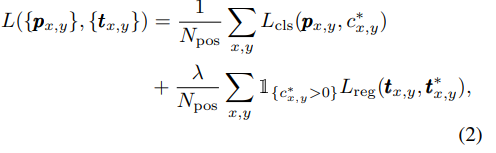

$L_{cls}$ is focal the loss function for classification as seen in the paper Focal Loss for Dense Object Detection which is defined as $FL(p_t)= -\alpha_t(1-p_t)^\gamma log(p_t)$ where $\alpha$ is a balancing parameter. The loss function down weights easy examples and the focusing parameter $\gamma$ adjusts the rate of down weighting these easy examples. When $\gamma$ is 0 the focal loss is equivalent to cross entropy loss. We can think of this as being analagous to boosting where mis-classified points (hard examples) are given greater importance/weight and easy examples are not. It is important to note, though, that we have our factors in the loss function which is unlike boosting where weights are adjusted outside of a loss function. $L_{reg}$ is the IOU loss seen in UnitBox and is defined as $-ln$(Intersection of Bounding Boxes/Union of Bounding Boxes). Lambda is a weight for balancing the two terms and is set to 1 for our purposes. We include the indicator function such that if we classify a positive example (i.e. not background) we consider the IOU loss. During Inference we obtain the classification scores $p_{x,y}$ and the regression prediction $t_{x,y}$ for each feature map. They choose $p_{x,y}$ > 0.05 as positive samples and invert $l^*, t^*, r^*, b^*$ to obtain bounding boxes.

One issue that is posed with FCOS is that it can result in a relatively low upper bound of a recall rate that can potentially be achieved due to large strides in the feature pyramid network. However, this can be counteracted by lowering the IOU threshold for positive anchor boxes. Additionally, they will empirically show that this is not an issue for their architecture. Another issue issue is that the overlapping ground truth boxes can cause issues on which pixels to regress on. I mentioned this previously as an issue with FCNs, so how is this alleviated in the new structure? We utilize multi-level prediction which propels the new architecture to state of the art performance when comparing to anchor basd methods. With this issues addressed, they utilize five level of feature maps in the backbone CNNs followed by a 1x1 convolution. At each level, the range of the bounding box regression is limited such that we do not regress on negative samples. They note that after using multi-level prediction in FCOS, it is still lacking compared to other methods due to low-quality predicted bounding boxes.

This is where the center-ness branch is implemented in parallel with the classification branch. First, we define centerness as:

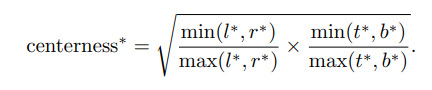

The values of the centerness thus range from 0 to 1 and is trained with binary cross entropy loss. The final score for ranking the bounding boxes takes centerness and multiplies it with the classification score and thus filters out low quality bounding boxes with non-maximum suppression. They note that this process improves the performance drastically.

Next, the experiments. They utilized the COCO dataset as their benchmark and ResNet-50 as their backbone netowrk. The weights are initialized with pre-training on ImageNet classification and replicate weight initialization of new layers as in RetinaNet. First we examine best possible recall--the ratio of the number of ground truth bounding boxes a detector can recall at most divided by all ground truth bounding boxes. With the inclusion of the feature pyramid network, FCOS achieves a BPR of 98.40% (quite impressive!). Looking at the table below, we see that it achieves state of the art levels comparing to one of the leading anchor based methods RetinaNet.

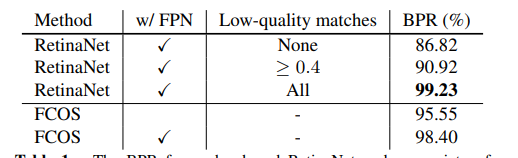

One known issue I mentioned previously is that FCN detectors have a large amount of ambiguous samples, where the bounding box regions of ground truth examples overlap. Without the feature pyramid network, 23% of the samples are ambiguous while only 7% are with the inclusion of the feature pyramid network. This is due to the fact that overlapped objects are assigned to different feature levels. Additionally, the researchers only consider ambiguous samples where the overlapping objects are of different classes. Taking this into consideration, they found that only 2.3% of detected boxes are produced by ambiguous locations. Next they test including/excluding the centerness layer. They found that including centerness increases average precision by ~3.5% and which outpeforms RetinaNet. While they did not include IOU thresholds, they found that they increased performance. The results are displayed in the table below including/excluding centerness

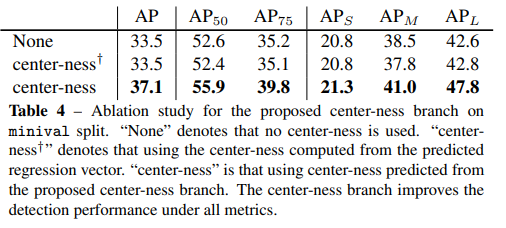

Comparing to the anchor based detection model RetinaNet, they used group normalization in the new convolutional layers to make training more stable. The feature map level $P_5$ from feature pyramid network is used to produce feature maps levels $P_6$ and $P_7$ compared to just using the backbone CNN's feature map, $C_5$ as is the case in Retina Net. To give an apples-to-apples comparison they change their structure to that of RetinaNet by using the backbone CNN's feature map to produce $P_6$ and $P_7$ and found that FCOS performed nearly identically to the anchor based detector. They also argue that the parameters used to train in this comparison were tuned for RetinaNet and that using tuning specific to FCOS would likely result in a larger gap in performance. The authors also compare to other state of the art networks and the results are summarized below:

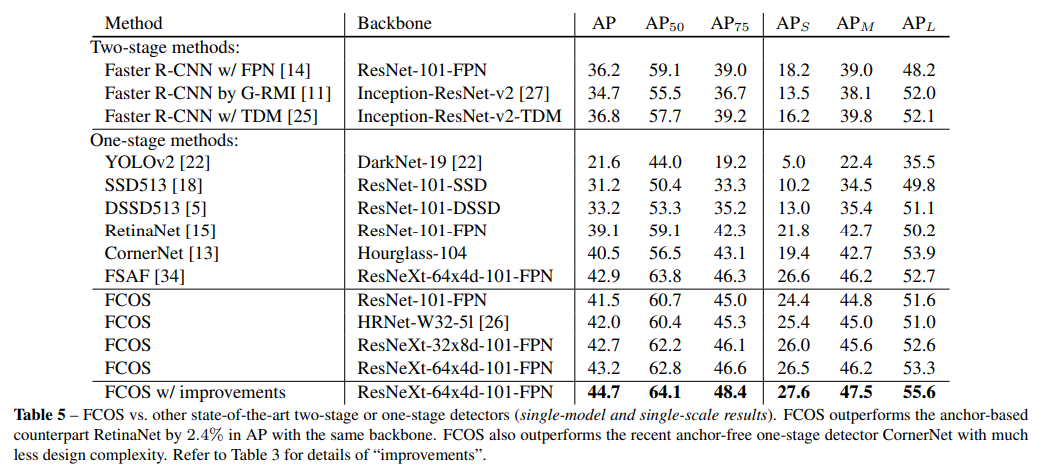

We can see in the table above that FCOS outperforms all other state of the art models, anchor-based or not, and is generally much simpler than these other models. We see a drastic improvement over Faster R-CNN and the anchor free method CornerNet, suggesting that anchor based methods can potentially be a thing of the past for object detection. Furthermore, they note that even without their centerness layer they still outperform the state of the art two stage detector Faster R-CNN with the use of the feature pyramid network. One thing they do not mention is the speed at evaluation. A large focus of the Faster R-CNN paper was it's blazing fast ability at the time of inference and while FCOS can outperform Faster R-CNN it may not be as useful if latency is increased drastically. The paper closes out by reiterating the efficiency and effectiveness of FCOS and that it should be considered a strong alternative to main stream detectors and for its use in other intance level recognition tasks.


